# 0) Setup environment

In [1]:
%%capture --no-display

!pip install pandas scikit-learn seaborn nltk wordcloud umap-learn numpy==1.24.0

In [74]:
import re
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk import word_tokenize
from nltk.corpus import wordnet
import umap.umap_ as umap

In [3]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/guillaume/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/guillaume/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/guillaume/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/guillaume/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# Impose a seed for reproducibility
random_seed = 421

# 1) Dataset

In [5]:
dataset = fetch_20newsgroups(
    remove=("headers", "footers", "quotes"),
    subset="all",
    shuffle=True,
    random_state=random_seed,
    categories=['misc.forsale', 'soc.religion.christian', 'comp.graphics', 'talk.politics.misc', 'sci.space', 'rec.sport.hockey'],
)

In [6]:
# Create a DataFrame from the dataset
df = pd.DataFrame({'text': dataset.data, 'label': dataset.target})

# Map target labels to target names
df['label'] = df['label'].map(lambda x: dataset.target_names[x])


from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder()
df['label_indices'] = label_encoder.fit_transform(df['label'])
df.head()

,text,label,label_indices
0,\nNo one is questioning whether Mr. King is bl...,talk.politics.misc,5
1,"\n\nWhatever you do, don't FTP to the sites li...",comp.graphics,0
2,\nIt was Clint Malarchuk's neck cut by Uwe Kru...,rec.sport.hockey,2
3,\n\nWow. So that's probably the reason why cu...,rec.sport.hockey,2
4,\nThe front covers should be available from So...,misc.forsale,1


In [7]:
unique_labels = np.unique(df['label'])
number_of_unique_labels = len(unique_labels)
number_of_samples = len(df['text'])
print('There are {} different labels that describe a total of {} documents.'.format(
    number_of_unique_labels, number_of_samples))

There are 6 different labels that describe a total of 5706 documents.


The 20 different labels are the following. We note that the distribution is not uniform, there is a class imbalance.
**TODO**

0: comp.graphics
1: misc.forsale
2: rec.sport.hockey
3: sci.space
4: soc.religion.christian
5: talk.politics.misc


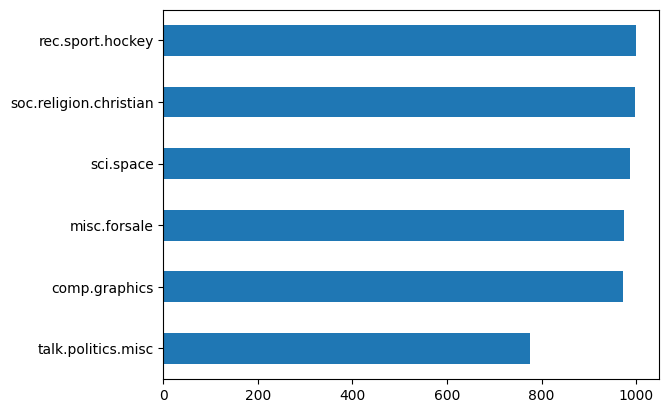

In [8]:
for label_index in range(number_of_unique_labels):
    print('{}: {}'.format(label_index, unique_labels[label_index]))
    
df.label.value_counts().plot.barh()
plt.gca().invert_yaxis()

Below we provide an example of samples taken from three different labels:

In [9]:
# Example entry from "comp.graphics"
index=9
print('Example: sample number {} (label: {})\n{}\n\n{}\n'.format(
    index, df.label[index], '-' * 64, df.text[index]))

Example: sample number 9 (label: comp.graphics)
----------------------------------------------------------------

Hello,

    I have been searching for a quality image enhancement and
    manipulation package for Unix/X/Motif platforms that is comparable
    to Adobe Photo Shop for the Mac.

    I have not been able to find any, and would appreciate any
    information about such products you could provide.

    I would be particularly interested in software that runs on HP or
    Sun workstations, and does not require special add-in hardware, but
    would also be interested in other solutions.


Thank You.
Wayne



In [10]:
# Example entry from "soc.religion.christian"
index=37
print('Example: sample number {} (label: {})\n{}\n\n{}\n'.format(
    index, df.label[index], '-' * 64, df.text[index]))

Example: sample number 37 (label: soc.religion.christian)
----------------------------------------------------------------

Over the years, I have met Christians who are not associated with
any local church and are not members of any local church. This is
an issue that may be very personal, but is important.  What does
the Bible say about this and how can we encourage our friends with
regard to this issue?



In [11]:
# Example entry from "soc.religion.christian"
index=81
print('Example: sample number {} (label: {})\n{}\n\n{}\n'.format(
    index, df.label[index], '-' * 64, df.text[index]))

Example: sample number 81 (label: talk.politics.misc)
----------------------------------------------------------------

->     >Now let me get this straight. After a nice, long rant about
->     >how people need to take personal responsibility for their
->     >economic and social lives, all of a sudden 1960's radicals
->     >(such as me, I guess) are responsible for poor people's
->     >lifestyles? Tell me how that works--or do you think that poor
->     >people are just too dumb to think for themselves?
->     >
->     >There are many reasons for the disintegration of the family
->     >and support systems in general among this nation's poor.
->     >Somehow I don't think Murphy Brown--or Janis Joplin--is at
->     >the top of any sane person's list.
->     >
->     >You want to go after my generation's vaunted cultural
->     >revolution for a lasting change for the worse, try so-called
->     >"relevant" or "values" education. Hey, it seemed like a good
->     >idea at the time. 

In [12]:
# Example entry from "rec.sport.hockey"
index=86
print('Example: sample number {} (label: {})\n{}\n\n{}\n'.format(
    index, df.label[index], '-' * 64, df.text[index]))

Example: sample number 86 (label: rec.sport.hockey)
----------------------------------------------------------------



Ah yes.  California.  Did the San Francisco Bay area media report that
Joe Montana is rumoured to be the leading candidate to replace fired
San Jose Sharks coach George Kingston?  Apparently Montana is not only
coveted for his winning attitude, but as a playing coach he will be
expected to quarterback the powerplay.

Good thing those walls are so soft, eh Rollie?


-- 



In [13]:
# Example entry from "misc.forsales"
index=88
print('Example: sample number {} (label: {})\n{}\n\n{}\n'.format(
    index, df.label[index], '-' * 64, df.text[index]))

Example: sample number 88 (label: misc.forsale)
----------------------------------------------------------------

SOMEONE PLEASE BUY THESE BOOKS!!!!!  I AM NOT ASKING MUCH!!!!!!

LIQUIDATION!!!!!! Send me your offer!  No reasonable offer refused!
First come first served! I JUST WANT TO GET RID OF THESE BOOKS!!!
JUST MAKE ME AN OFFER!!!!!  

* Calculus w/ Analytic Geometry by Authur B. Simon (copyright date 1982), below avg condition but still readable!  Give me $8 (shipping incl) and its yours!

* Writing good software in Fortran, Graham Smith.  $12 (shipp incl) 

* General Chemistry Principles & Modern Applications, R. Petrucci, fourth
  edition.  Big Book! (this book + following 2 books $20 for all 3!!)

* Solutions manual for Chemistry book. 

* Study guide for Chemistry book. 


Send me your offers via email at 02106@chopin.udel.edu





In [14]:
# Example entry from "sci.space"
index=146
print('Example: sample number {} (label: {})\n{}\n\n{}\n'.format(
    index, df.label[index], '-' * 64, df.text[index]))

Example: sample number 146 (label: sci.space)
----------------------------------------------------------------


Alan,

	don't forget,  a HUGE  cost for airliner developement is FAA
certification.  the joke is when the paperwork  exceeds teh weight
of the airplane,  it will fly.

The SR-71, and teh X-15  both highly ambitious  aero-space projects were done
on very narrow engineering budgets.   Partly because they didn't spend much
on paper  pushing.   There is some company in missouri  trying to
get funding to build light commercial transporters  on a low cost basis,
mostly by reducing FAA  certification costs.



### Systematic cleaning

In [15]:
# Remove HTML tages (everything within the "<>" brackets")
def remove_html_tags(text):
    return re.sub(r'<.*?>', '', text)
df['text'] = df['text'].apply(remove_html_tags)

In [16]:
# Keep only alphabetical characters (26 roman letters)
def keep_only_alphas(text):
    return ' '.join(re.findall("[a-zA-Z]+", text))
df['text'] = df['text'].apply(keep_only_alphas)

In [17]:
# Set to lowercase
def set_to_lowercase(text):
    return text.lower()
df['text'] = df['text'].apply(set_to_lowercase)

In [18]:
# Remove most common words ("it", "your", "as", etc.) as they are void of informational content for clustering
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [19]:
# Remove short words that are only one or two letters long
def remove_short_words(text):
    length_threshold = 2
    return ' '.join(word for word in text.split() if len(word)>length_threshold)
df['text'] = df['text'].apply(remove_short_words)

In [20]:
# Lemmatization
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:         
        return wordnet.NOUN

def apply_lemmatization(text):
    word_tokens = word_tokenize(text)    
    pos_tags = pos_tag(word_tokens)
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word_tokens, get_wordnet_pos(tag)) for word_tokens, tag in pos_tags]
    return ' '.join(lemmatized_words)
df['text'] = df['text'].apply(apply_lemmatization)    

### Tailored cleaning

In [21]:
# We print the 200 most common words of the entire dataset
count = Counter(w for x in df['text'] for w in x.split())
most_commons = count.most_common(200)
print(most_commons)

[('would', 3526), ('one', 3190), ('people', 2119), ('like', 2072), ('god', 1958), ('also', 1939), ('think', 1918), ('know', 1856), ('get', 1673), ('time', 1658), ('new', 1658), ('space', 1502), ('good', 1368), ('well', 1341), ('first', 1314), ('may', 1312), ('see', 1275), ('could', 1267), ('image', 1262), ('edu', 1243), ('two', 1178), ('even', 1170), ('much', 1167), ('make', 1149), ('use', 1137), ('many', 1111), ('way', 1078), ('say', 1029), ('system', 990), ('game', 953), ('want', 946), ('please', 933), ('graphics', 922), ('believe', 898), ('going', 878), ('said', 866), ('need', 855), ('right', 850), ('year', 843), ('data', 833), ('used', 818), ('last', 806), ('jpeg', 804), ('point', 803), ('since', 803), ('years', 802), ('something', 793), ('back', 789), ('made', 789), ('available', 787), ('work', 786), ('program', 783), ('still', 770), ('president', 768), ('mail', 765), ('things', 747), ('find', 746), ('team', 745), ('software', 739), ('anyone', 722), ('etc', 719), ('power', 716), (

In [22]:
# We identify and remove words that do not carry a semantically meaningful information for clustering
extra_stop_words = ['would', 'one', 'get', 'also', 'could', 'may', 'two', 'much', 'many', 'going', 'three']
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (extra_stop_words)]))

### Visualization of the cleansed dataset

In [23]:
# Example entry from "soc.religion.christian"
index=37
print('Example: sample number {} (label: {})\n{}\n\n{}\n'.format(
    index, df.label[index], '-' * 64, df.text[index]))

Example: sample number 37 (label: soc.religion.christian)
----------------------------------------------------------------

years met christians associated local church members local church issue personal important bible say encourage friends regard issue



In [24]:
# Example entry from "soc.religion.christian"
index=81
print('Example: sample number {} (label: {})\n{}\n\n{}\n'.format(
    index, df.label[index], '-' * 64, df.text[index]))

Example: sample number 81 (label: talk.politics.misc)
----------------------------------------------------------------

let straight nice long rant people need take personal responsibility economic social lives sudden radicals guess responsible poor people lifestyles tell works think poor people dumb think reasons disintegration family support systems general among nation poor somehow think murphy brown janis joplin top sane person list want generation vaunted cultural revolution lasting change worse try called relevant values education hey seemed like good idea time know needed real education first mean took granted generation spoiled irresponsible depression create mothers fathers determined kids want anything overboard creating nation brats consider contrast famous events july apollo woodstock group large numbers people feed reverted cultural level primitives defecation public etc group assembled took care dispersed damage deaths large numbers drug problems woodstock called biggest 

In [25]:
# Example entry from "rec.sport.hockey"
index=86
print('Example: sample number {} (label: {})\n{}\n\n{}\n'.format(
    index, df.label[index], '-' * 64, df.text[index]))

Example: sample number 86 (label: rec.sport.hockey)
----------------------------------------------------------------

yes california san francisco bay area media report joe montana rumoured leading candidate replace fired san jose sharks coach george kingston apparently montana coveted winning attitude playing coach expected quarterback powerplay good thing walls soft rollie



In [26]:
# Example entry from "misc.forsales"
index=88
print('Example: sample number {} (label: {})\n{}\n\n{}\n'.format(
    index, df.label[index], '-' * 64, df.text[index]))

Example: sample number 88 (label: misc.forsale)
----------------------------------------------------------------

someone please buy books asking liquidation send offer reasonable offer refused first come first served want rid books make offer calculus analytic geometry authur simon copyright date avg condition still readable give shipping incl writing good software fortran graham smith shipp incl general chemistry principles modern applications petrucci fourth edition big book book following books solutions manual chemistry book study guide chemistry book send offers via email chopin udel edu



In [27]:
# Example entry from "sci.space"
index=146
print('Example: sample number {} (label: {})\n{}\n\n{}\n'.format(
    index, df.label[index], '-' * 64, df.text[index]))

Example: sample number 146 (label: sci.space)
----------------------------------------------------------------

alan forget huge cost airliner developement faa certification joke paperwork exceeds teh weight airplane fly teh highly ambitious aero space projects done narrow engineering budgets partly spend paper pushing company missouri trying funding build light commercial transporters low cost basis mostly reducing faa certification costs



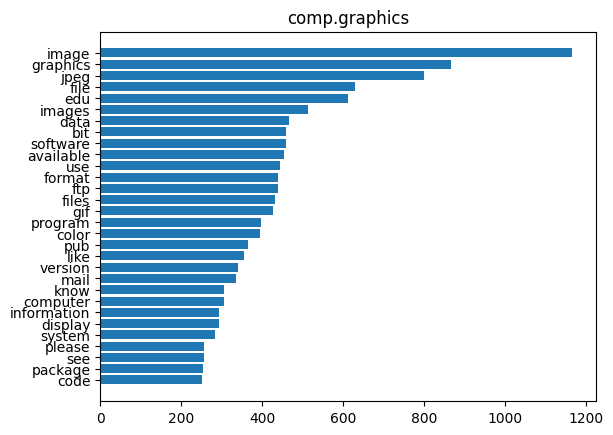

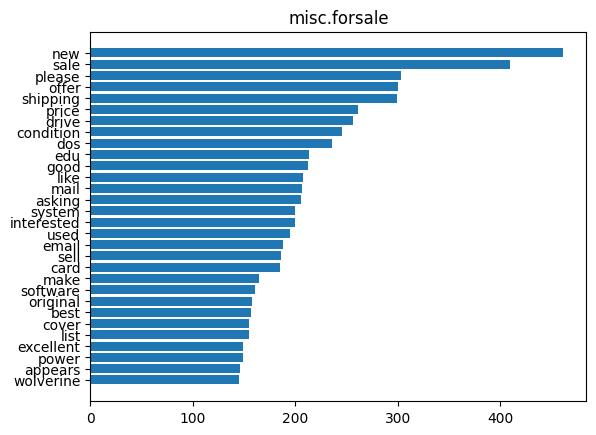

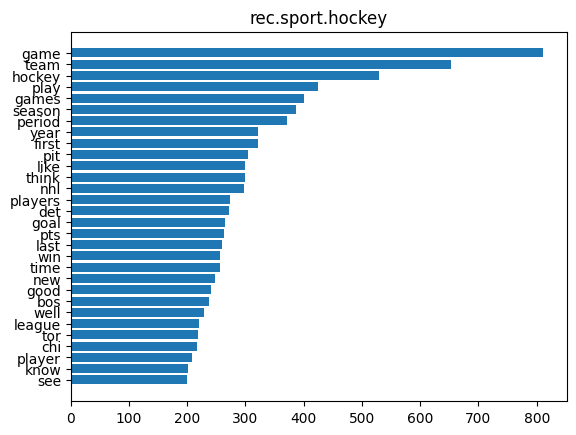

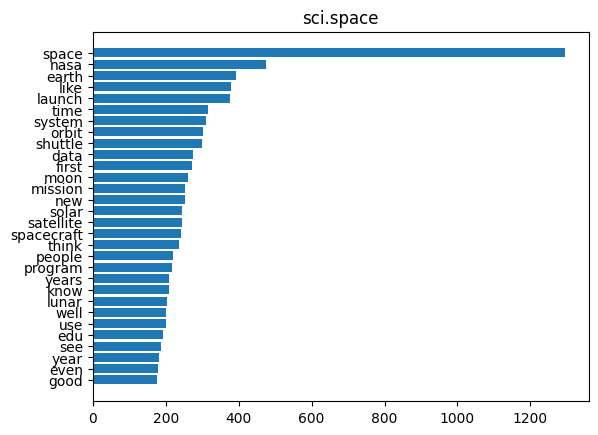

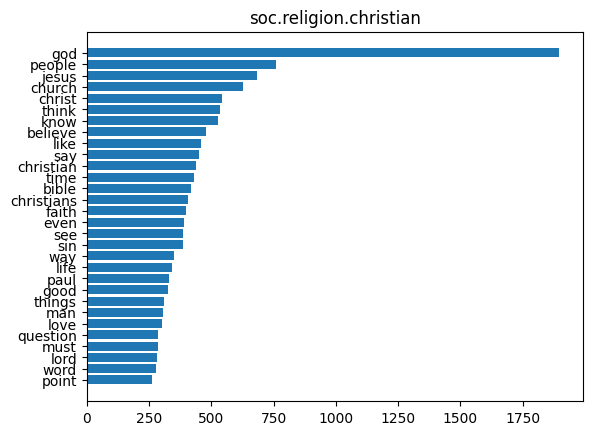

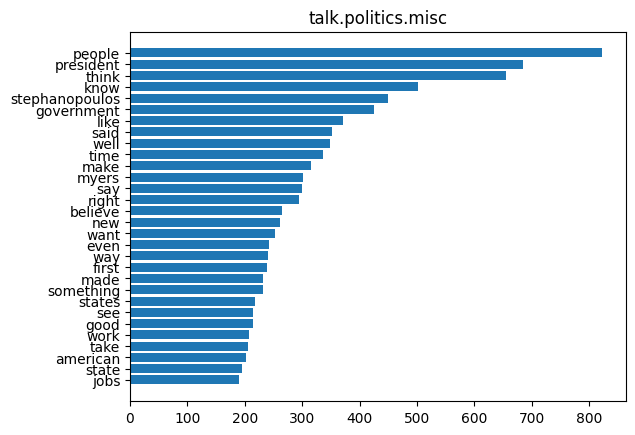

In [28]:
# We display the most common 30 words for each label. We observe that a strong semantic association emmerges between the label of each newsgroup and the most common words.
for label_index in range(number_of_unique_labels):
    label = unique_labels[label_index]
    
    df_single = df[df['label'].isin({label})]
    count = Counter(w for x in df_single['text'] for w in x.split())
    most_commons = count.most_common(30)

    plt.figure()
    plt.barh(*zip(*most_commons));
    plt.gca().invert_yaxis()
    plt.title(label)

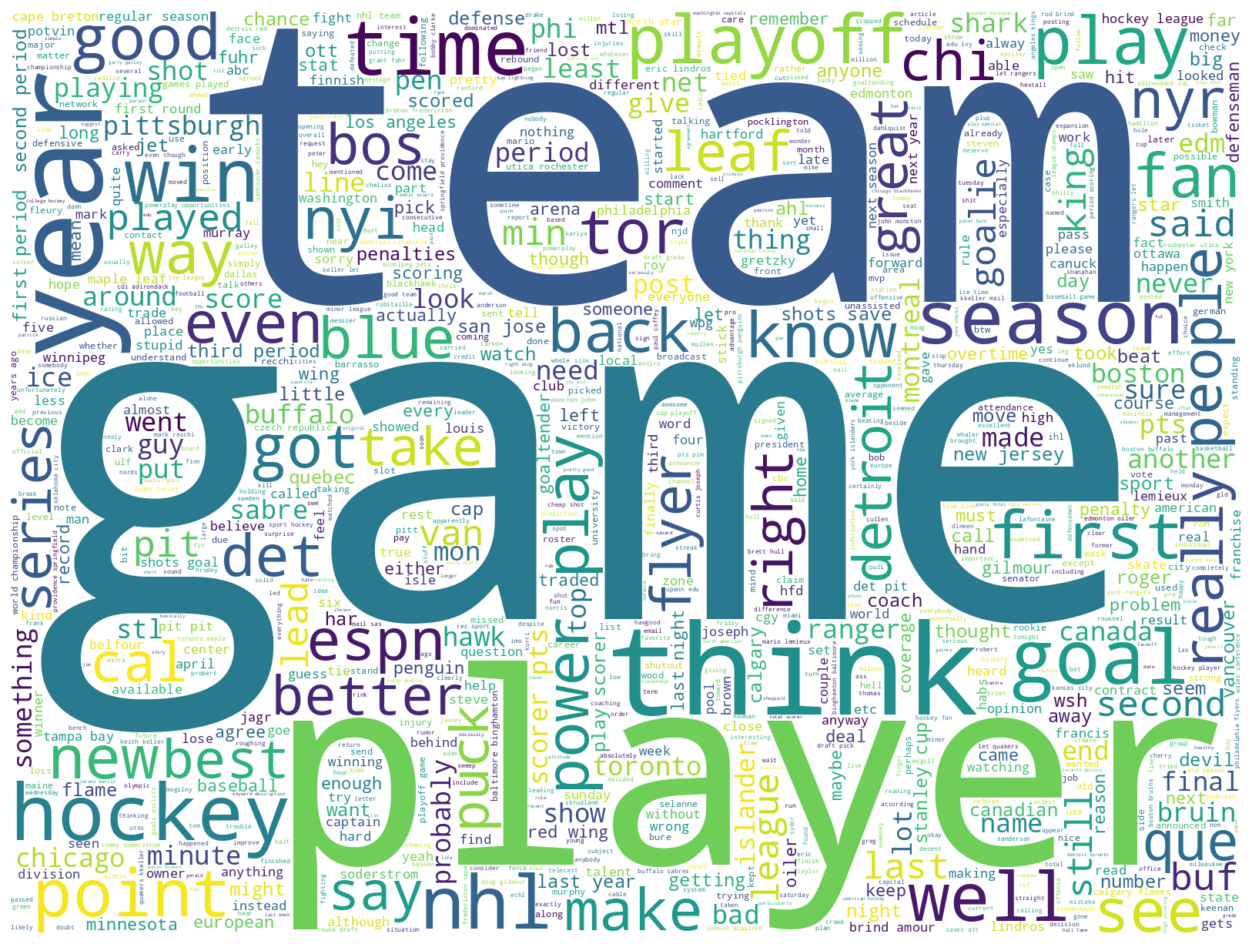

In [29]:
# Alternative representation of the most common words, for the label 'rec.sport.hockey' 
wordcloud = WordCloud(background_color="white", max_words=1000, random_state = random_seed, width=1600, height=1200)
df_hockey = df[df['label'].isin({'rec.sport.hockey'})]
df_hockey = df_hockey.text.tolist()
df_hockey = ' '.join(df_hockey)
wordcloud.generate(df_hockey)
plt.figure(figsize=(16, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Vectorization

In [ ]:
vectorizer = TfidfVectorizer(min_df=3)
vectors = vectorizer.fit_transform(df['text'])
tokens = vectorizer.get_feature_names_out()

print('Number of entries: {}'.format(vectors.shape[0]))
print('Number of dimensions: {}'.format(vectors.shape[1]))
print('Percentage of non-zero entries: {:.3f}%'.format(100 * vectors.nnz / (vectors.shape[0] * vectors.shape[0])))
print('Example of 100 random tokens: {}'.format(tokens[np.random.permutation(vectors.shape[1])[:100]]))

### Principal Components Analysis

In [31]:
n_components = 200
pca = PCA(n_components=n_components, random_state=random_seed)

In [32]:
X_new = pca.fit_transform(vectors)

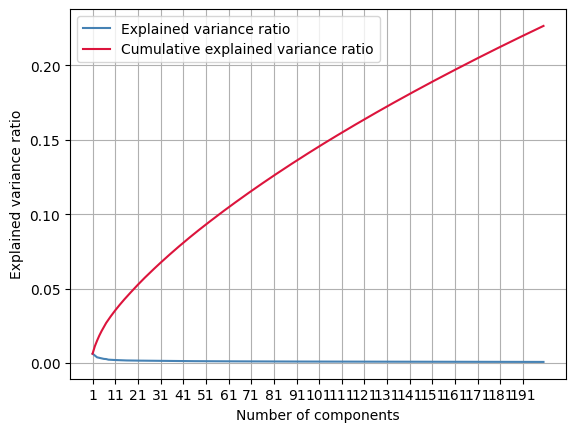

In [33]:
plt.figure()
plt.plot(range(1, n_components+1), pca.explained_variance_ratio_, color='steelblue', label='Explained variance ratio')
plt.plot(range(1, n_components+1), pca.explained_variance_ratio_.cumsum(), color='crimson', label='Cumulative explained variance ratio')
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')
plt.xticks(range(1, n_components+1, 10))
plt.legend()
plt.grid()
plt.show()

In [34]:
print(X_new.shape)

(5706, 200)


0: comp.graphics
1: misc.forsale
2: rec.sport.hockey
3: sci.space
4: soc.religion.christian
5: talk.politics.misc


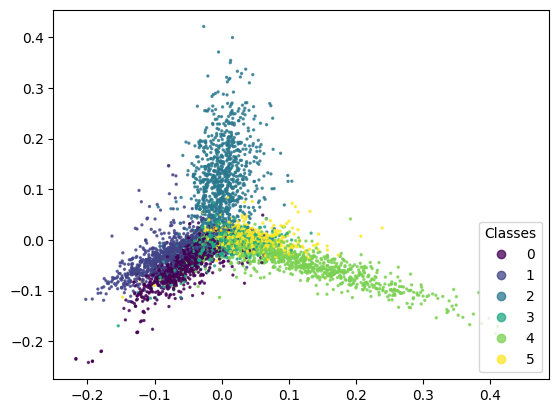

In [35]:
plt.figure()
scatter = plt.scatter(X_new[:,0], X_new[:,1], c=df['label_indices'], alpha=0.75, s=2)
u = np.unique(df['label_indices'])
plt.legend(scatter.legend_elements()[0], u, loc='lower right', title='Classes')

for label_index in range(number_of_unique_labels):
    print('{}: {}'.format(label_index, unique_labels[label_index]))

# KMeans

In [135]:
# We define the transformation object
km = KMeans(n_clusters=number_of_unique_labels, init='k-means++', max_iter=500, n_init=100, random_state=random_seed)

In [136]:
# We apply the object to the data
km.fit(vectors)

KMeans(max_iter=500, n_clusters=6, n_init=100, random_state=421)

In [ ]:
# We print the 20 most 
centroids = km.cluster_centers_.argsort()[:,::-1]
for cluster_index in range(number_of_unique_labels):
    print('Cluster {}'.format(cluster_index, unique_labels[cluster_index]))
    for centroid_index in centroids[cluster_index, :20]:
        print('{} '.format(terms[centroid_index]), end='')
    print('\n')

(5706,)
(6, 16109)
5
[4.95241085e-04 3.40596580e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 3.48620746e-05
 0.00000000e+00 2.17980821e-05]


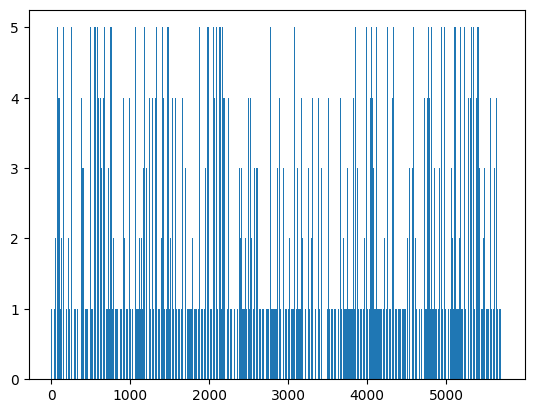

In [133]:
print(km.labels_.shape)
print(km.cluster_centers_.shape)
print(km.labels_[1])
print(km.cluster_centers_[:,0])
print(km.cluster_centers_[:,1])

plt.figure()
plt.bar(range(number_of_samples), km.labels_)
plt.show()

## Uniform Manifold Approximation and Projection for Dimension Reduction (UMAP)

In [75]:
n_components = 2
umap = umap.UMAP(n_components=n_components, metric='cosine', n_neighbors=51, min_dist=1, spread=3, init='pca')

In [76]:
embeddings = umap.fit_transform(vectors)

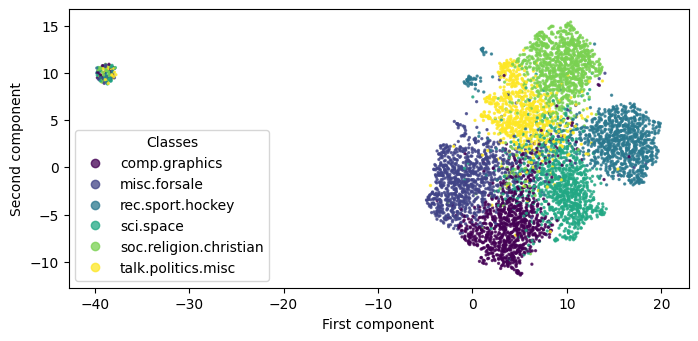

In [89]:
# Display the manifold embeddings
plt.figure(figsize=(8, 8))
scatter = plt.scatter(embeddings[:,0], embeddings[:,1], c=df['label_indices'], alpha=0.75, s=2)
plt.legend(scatter.legend_elements()[0], unique_labels, loc='lower left', title='Classes')
ax = plt.gca()
ax.set_aspect('equal')
plt.xlabel('First component')
plt.ylabel('Second component')
plt.show()